In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import tqdm
import pickle
from sklearn.preprocessing import Normalizer

import robustness_model

/Users/sang-geon/Documents/UCI_BIASLab/HDC_Robustness/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data = datasets.MNIST(root = './datasets/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './datasets/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./datasets/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
train_data.data.shape, train_data.targets.shape

(torch.Size([60000, 28, 28]), torch.Size([60000]))

In [5]:
X_train = train_data.data
y_train = train_data.targets
X_test = test_data.data
y_test = test_data.targets

In [6]:
scaler = Normalizer().fit(X_train.reshape(-1, 28*28))
X_train = scaler.transform(X_train.reshape(-1, 28*28))
X_test = scaler.transform(X_test.reshape(-1, 28*28))

In [7]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]))

In [9]:
original_dim = 28*28
dim = 10000

In [10]:
encoder = robustness_model.FHRREncoder(original_dim, dim)
model = robustness_model.MultiClassificationModel(encoder, 10, in_dim=original_dim, dim=dim)
model.bundling(X_train, y_train)

100%|██████████| 45/45 [04:15<00:00,  5.69s/it]


In [11]:
def overall_robustness(model: robustness_model.MultiClassificationModel, c1, c2, X):
    
    ep1s = []
    ep2s = []
    ep3s = []

    # L3 = model.get_lipschitz_constant()

    max_X, method2_history = model.get_lipschitz_constant_gd(c1, c2)
    L2 = method2_history[-1]
    max_X, L, method3_history = model.get_conservative_lipschitz_constant_gd(c1, c2)
    L3 = L

    # plt.plot(method2_history)
    # plt.ylabel('$|| \\nabla r(x) ||$')
    # plt.xlabel('Iteration')
    # plt.show()

    # plt.plot(method3_history)
    # plt.ylabel('$\\alpha$')
    # plt.xlabel('Iteration')
    # plt.show()
    
    for x in tqdm.tqdm(X):
        
        L1 = model.get_linear_approximation(c1, c2, x)
        # L2 = model.get_conservative_lipschitz_constant(x)

        ep1 = model.get_eps(c1, c2, x, L1)
        ep2 = model.get_eps(c1, c2, x, L2)
        ep3 = model.get_eps(c1, c2, x, L3)

        ep1s.append(ep1)
        ep2s.append(ep2)
        ep3s.append(ep3)
    
    return torch.tensor(ep1s), torch.tensor(ep2s), torch.tensor(ep3s)

In [12]:
all_train_robustness = []
i = 0
for c1 in range(10):
    for c2 in range(c1 + 1, 10):
        ep1s_train, ep2s_train, ep3s_train = overall_robustness(model, c1, c2, X_train[(y_train == c1) | (y_train == c2)])
        print(c1, c2, ep1s_train.mean(), ep2s_train.mean(), ep3s_train.mean())
        all_train_robustness.append((ep1s_train, ep2s_train, ep3s_train))
        i += 1


100%|██████████| 12665/12665 [01:29<00:00, 141.19it/s]


0 1 tensor(0.4850) tensor(0.5150) tensor(0.2460)


100%|██████████| 11881/11881 [01:25<00:00, 138.38it/s]


0 2 tensor(0.2912) tensor(0.3402) tensor(0.1654)


100%|██████████| 12054/12054 [01:22<00:00, 145.42it/s]


0 3 tensor(0.2894) tensor(0.3440) tensor(0.1661)


100%|██████████| 11765/11765 [01:29<00:00, 131.00it/s]


0 4 tensor(0.3319) tensor(0.3797) tensor(0.1842)


100%|██████████| 11344/11344 [01:23<00:00, 136.17it/s]


0 5 tensor(0.3910) tensor(0.4679) tensor(0.2196)


100%|██████████| 11841/11841 [01:20<00:00, 146.37it/s]


0 6 tensor(0.3033) tensor(0.3500) tensor(0.1719)


100%|██████████| 12188/12188 [01:23<00:00, 145.87it/s]


0 7 tensor(0.3495) tensor(0.3935) tensor(0.1938)


100%|██████████| 11774/11774 [01:20<00:00, 146.56it/s]


0 8 tensor(0.2899) tensor(0.3453) tensor(0.1690)


100%|██████████| 11872/11872 [01:20<00:00, 146.90it/s]


0 9 tensor(0.3357) tensor(0.3819) tensor(0.1877)


100%|██████████| 12700/12700 [01:26<00:00, 146.42it/s]


1 2 tensor(0.1277) tensor(0.1392) tensor(0.0682)


100%|██████████| 12873/12873 [01:28<00:00, 146.12it/s]


1 3 tensor(0.4191) tensor(0.4637) tensor(0.2205)


100%|██████████| 12584/12584 [01:27<00:00, 143.78it/s]


1 4 tensor(0.3546) tensor(0.3912) tensor(0.1889)


100%|██████████| 12163/12163 [01:27<00:00, 138.50it/s]


1 5 tensor(0.4624) tensor(0.4944) tensor(0.2342)


100%|██████████| 12660/12660 [01:27<00:00, 143.92it/s]


1 6 tensor(0.5916) tensor(0.6296) tensor(0.2928)


100%|██████████| 13007/13007 [01:31<00:00, 142.03it/s]


1 7 tensor(0.4197) tensor(0.4600) tensor(0.2198)


100%|██████████| 12593/12593 [01:27<00:00, 143.80it/s]


1 8 tensor(0.3738) tensor(0.4159) tensor(0.1996)


100%|██████████| 12691/12691 [01:28<00:00, 143.42it/s]


1 9 tensor(0.3777) tensor(0.4156) tensor(0.1998)


100%|██████████| 12089/12089 [01:24<00:00, 143.02it/s]


2 3 tensor(0.1442) tensor(0.1655) tensor(0.0802)


100%|██████████| 11800/11800 [01:22<00:00, 143.00it/s]


2 4 tensor(0.1100) tensor(0.1264) tensor(0.0601)


100%|██████████| 11379/11379 [01:19<00:00, 143.12it/s]


2 5 tensor(0.1426) tensor(0.1666) tensor(0.0789)


100%|██████████| 11876/11876 [01:22<00:00, 143.85it/s]


2 6 tensor(0.1307) tensor(0.1543) tensor(0.0743)


100%|██████████| 12223/12223 [01:25<00:00, 143.43it/s]


2 7 tensor(0.2113) tensor(0.2428) tensor(0.1183)


100%|██████████| 11809/11809 [01:22<00:00, 143.83it/s]


2 8 tensor(0.3563) tensor(0.4160) tensor(0.1998)


100%|██████████| 11907/11907 [01:23<00:00, 142.70it/s]


2 9 tensor(0.1276) tensor(0.1492) tensor(0.0739)


100%|██████████| 11973/11973 [01:23<00:00, 144.06it/s]


3 4 tensor(0.1853) tensor(0.2182) tensor(0.1059)


100%|██████████| 11552/11552 [01:21<00:00, 142.54it/s]


3 5 tensor(0.1296) tensor(0.1577) tensor(0.0759)


100%|██████████| 12049/12049 [01:23<00:00, 143.91it/s]


3 6 tensor(0.1937) tensor(0.2303) tensor(0.1128)


100%|██████████| 12396/12396 [01:26<00:00, 142.81it/s]


3 7 tensor(0.2580) tensor(0.2911) tensor(0.1439)


100%|██████████| 11982/11982 [01:23<00:00, 143.42it/s]


3 8 tensor(0.1760) tensor(0.2136) tensor(0.1057)


100%|██████████| 12080/12080 [01:24<00:00, 143.68it/s]


3 9 tensor(0.2076) tensor(0.2425) tensor(0.1197)


100%|██████████| 11263/11263 [01:18<00:00, 143.82it/s]


4 5 tensor(0.0787) tensor(0.0904) tensor(0.0445)


100%|██████████| 11760/11760 [01:21<00:00, 143.77it/s]


4 6 tensor(0.1133) tensor(0.1347) tensor(0.0662)


100%|██████████| 12107/12107 [01:24<00:00, 143.35it/s]


4 7 tensor(0.1167) tensor(0.1336) tensor(0.0662)


100%|██████████| 11693/11693 [01:21<00:00, 143.63it/s]


4 8 tensor(0.1388) tensor(0.1680) tensor(0.0827)


100%|██████████| 11791/11791 [01:22<00:00, 142.39it/s]


4 9 tensor(0.1419) tensor(0.1681) tensor(0.0802)


100%|██████████| 11339/11339 [01:18<00:00, 143.77it/s]


5 6 tensor(0.1707) tensor(0.2031) tensor(0.1003)


100%|██████████| 11686/11686 [01:22<00:00, 141.77it/s]


5 7 tensor(0.2782) tensor(0.3198) tensor(0.1545)


100%|██████████| 11272/11272 [01:18<00:00, 142.72it/s]


5 8 tensor(0.2089) tensor(0.2475) tensor(0.1224)


100%|██████████| 11370/11370 [01:19<00:00, 142.13it/s]


5 9 tensor(0.2263) tensor(0.2632) tensor(0.1295)


100%|██████████| 12183/12183 [01:23<00:00, 145.92it/s]


6 7 tensor(0.1079) tensor(0.1247) tensor(0.0611)


100%|██████████| 11769/11769 [01:21<00:00, 144.76it/s]


6 8 tensor(0.2444) tensor(0.2985) tensor(0.1432)


100%|██████████| 11867/11867 [01:21<00:00, 145.59it/s]


6 9 tensor(0.1602) tensor(0.1922) tensor(0.0944)


100%|██████████| 12116/12116 [01:23<00:00, 144.27it/s]


7 8 tensor(0.1948) tensor(0.2221) tensor(0.1074)


100%|██████████| 12214/12214 [01:24<00:00, 145.31it/s]


7 9 tensor(0.0960) tensor(0.1119) tensor(0.0532)


100%|██████████| 11800/11800 [01:21<00:00, 144.50it/s]

8 9 tensor(0.2025) tensor(0.2332) tensor(0.1148)


In [13]:
all_test_robustness = []
i = 0
for c1 in range(10):
    for c2 in range(c1 + 1, 10):
        ep1s_test, ep2s_test, ep3s_test = overall_robustness(model, c1, c2, X_test[(y_test == c1) | (y_test == c2)])
        print(c1, c2, ep1s_test.mean(), ep2s_test.mean(), ep3s_test.mean())
        all_test_robustness.append((ep1s_test, ep2s_test, ep3s_test))
        i += 1


100%|██████████| 2115/2115 [00:14<00:00, 145.61it/s]


0 1 tensor(0.4957) tensor(0.5247) tensor(0.2508)


100%|██████████| 2012/2012 [00:13<00:00, 145.08it/s]


0 2 tensor(0.2925) tensor(0.3417) tensor(0.1667)


100%|██████████| 1990/1990 [00:13<00:00, 145.03it/s]


0 3 tensor(0.2942) tensor(0.3503) tensor(0.1692)


100%|██████████| 1962/1962 [00:13<00:00, 145.87it/s]


0 4 tensor(0.3353) tensor(0.3839) tensor(0.1865)


100%|██████████| 1872/1872 [00:12<00:00, 144.18it/s]


0 5 tensor(0.3958) tensor(0.4702) tensor(0.2219)


100%|██████████| 1938/1938 [00:13<00:00, 145.49it/s]


0 6 tensor(0.2871) tensor(0.3355) tensor(0.1647)


100%|██████████| 2008/2008 [00:13<00:00, 145.96it/s]


0 7 tensor(0.3571) tensor(0.4032) tensor(0.1976)


100%|██████████| 1954/1954 [00:13<00:00, 145.48it/s]


0 8 tensor(0.2929) tensor(0.3502) tensor(0.1708)


100%|██████████| 1989/1989 [00:13<00:00, 145.95it/s]


0 9 tensor(0.3418) tensor(0.3906) tensor(0.1912)


100%|██████████| 2167/2167 [00:14<00:00, 144.74it/s]


1 2 tensor(0.1312) tensor(0.1439) tensor(0.0701)


100%|██████████| 2145/2145 [00:14<00:00, 146.07it/s]


1 3 tensor(0.4284) tensor(0.4712) tensor(0.2252)


100%|██████████| 2117/2117 [00:14<00:00, 146.13it/s]


1 4 tensor(0.3583) tensor(0.3937) tensor(0.1911)


100%|██████████| 2027/2027 [00:13<00:00, 146.23it/s]


1 5 tensor(0.4696) tensor(0.4976) tensor(0.2382)


100%|██████████| 2093/2093 [00:14<00:00, 145.85it/s]


1 6 tensor(0.5947) tensor(0.6283) tensor(0.2926)


100%|██████████| 2163/2163 [00:14<00:00, 145.26it/s]


1 7 tensor(0.4260) tensor(0.4669) tensor(0.2236)


100%|██████████| 2109/2109 [00:14<00:00, 145.97it/s]


1 8 tensor(0.3684) tensor(0.4073) tensor(0.1971)


100%|██████████| 2144/2144 [00:14<00:00, 144.98it/s]


1 9 tensor(0.3788) tensor(0.4195) tensor(0.2001)


100%|██████████| 2042/2042 [00:14<00:00, 144.69it/s]


2 3 tensor(0.1506) tensor(0.1736) tensor(0.0839)


100%|██████████| 2014/2014 [00:13<00:00, 144.55it/s]


2 4 tensor(0.1118) tensor(0.1280) tensor(0.0619)


100%|██████████| 1924/1924 [00:13<00:00, 142.51it/s]


2 5 tensor(0.1489) tensor(0.1727) tensor(0.0828)


100%|██████████| 1990/1990 [00:13<00:00, 146.16it/s]


2 6 tensor(0.1315) tensor(0.1552) tensor(0.0750)


100%|██████████| 2060/2060 [00:14<00:00, 146.16it/s]


2 7 tensor(0.2209) tensor(0.2544) tensor(0.1237)


100%|██████████| 2006/2006 [00:13<00:00, 146.22it/s]


2 8 tensor(0.3582) tensor(0.4166) tensor(0.2008)


100%|██████████| 2041/2041 [00:13<00:00, 146.43it/s]


2 9 tensor(0.1350) tensor(0.1599) tensor(0.0784)


100%|██████████| 1992/1992 [00:13<00:00, 146.57it/s]


3 4 tensor(0.1903) tensor(0.2255) tensor(0.1090)


100%|██████████| 1902/1902 [00:13<00:00, 141.85it/s]


3 5 tensor(0.1257) tensor(0.1535) tensor(0.0741)


100%|██████████| 1968/1968 [00:13<00:00, 144.97it/s]


3 6 tensor(0.1885) tensor(0.2252) tensor(0.1105)


100%|██████████| 2038/2038 [00:14<00:00, 145.38it/s]


3 7 tensor(0.2589) tensor(0.2955) tensor(0.1446)


100%|██████████| 1984/1984 [00:13<00:00, 145.54it/s]


3 8 tensor(0.1804) tensor(0.2186) tensor(0.1084)


100%|██████████| 2019/2019 [00:13<00:00, 146.83it/s]


3 9 tensor(0.2194) tensor(0.2559) tensor(0.1263)


100%|██████████| 1874/1874 [00:12<00:00, 146.34it/s]


4 5 tensor(0.0726) tensor(0.0836) tensor(0.0412)


100%|██████████| 1940/1940 [00:13<00:00, 145.55it/s]


4 6 tensor(0.1128) tensor(0.1355) tensor(0.0662)


100%|██████████| 2010/2010 [00:13<00:00, 146.49it/s]


4 7 tensor(0.1138) tensor(0.1306) tensor(0.0649)


100%|██████████| 1956/1956 [00:13<00:00, 146.49it/s]


4 8 tensor(0.1420) tensor(0.1730) tensor(0.0849)


100%|██████████| 1991/1991 [00:13<00:00, 143.63it/s]


4 9 tensor(0.1426) tensor(0.1683) tensor(0.0807)


100%|██████████| 1850/1850 [00:12<00:00, 146.09it/s]


5 6 tensor(0.1660) tensor(0.2004) tensor(0.0980)


100%|██████████| 1920/1920 [00:13<00:00, 145.68it/s]


5 7 tensor(0.2805) tensor(0.3183) tensor(0.1560)


100%|██████████| 1866/1866 [00:12<00:00, 144.18it/s]


5 8 tensor(0.2180) tensor(0.2572) tensor(0.1277)


100%|██████████| 1901/1901 [00:13<00:00, 146.08it/s]


5 9 tensor(0.2375) tensor(0.2742) tensor(0.1357)


100%|██████████| 1986/1986 [00:13<00:00, 146.79it/s]


6 7 tensor(0.1024) tensor(0.1193) tensor(0.0583)


100%|██████████| 1932/1932 [00:13<00:00, 142.45it/s]


6 8 tensor(0.2426) tensor(0.2961) tensor(0.1424)


100%|██████████| 1967/1967 [00:13<00:00, 146.65it/s]


6 9 tensor(0.1602) tensor(0.1935) tensor(0.0948)


100%|██████████| 2002/2002 [00:13<00:00, 145.75it/s]


7 8 tensor(0.1906) tensor(0.2176) tensor(0.1051)


100%|██████████| 2037/2037 [00:13<00:00, 145.94it/s]


7 9 tensor(0.0940) tensor(0.1092) tensor(0.0521)


100%|██████████| 1983/1983 [00:13<00:00, 146.11it/s]

8 9 tensor(0.2136) tensor(0.2490) tensor(0.1216)


In [14]:
with open('./all_train_robustness_.pickle', 'bw') as f:
    pickle.dump(all_train_robustness, f)
with open('./all_test_robustness_.pickle', 'bw') as f:
    pickle.dump(all_test_robustness, f)

In [15]:
with open('./MNIST_multimodel_.pickle', 'bw') as f:
    pickle.dump(model, f)

In [16]:
# fig, axes = plt.subplots(1, 3, dpi=300, figsize=(20, 5))
# axes[0].set_title('MNIST train set Method 1')
# axes[0].hist(ep1s_train, bins=30)
# axes[1].set_title('MNIST train set Method 2')
# axes[1].hist(ep2s_train, bins=30)
# axes[2].set_title('MNIST train set Method 3')
# axes[2].hist(ep3s_train, bins=30)
# fig.show()

In [17]:
# fig, axes = plt.subplots(1, 3, dpi=300, figsize=(20, 5))
# axes[0].set_title('MNIST test set Method 1')
# axes[0].hist(ep1s_test, bins=30)
# axes[1].set_title('MNIST test set Method 2')
# axes[1].hist(ep2s_test, bins=30)
# axes[2].set_title('MNIST test set Method 3')
# axes[2].hist(ep3s_test, bins=30)
# fig.show()

In [18]:
ep1_train = min([ep1s_train.mean() for ep1s_train, _, _ in all_train_robustness])
ep2_train = min([ep2s_train.mean() for _, ep2s_train, _ in all_train_robustness])
ep3_train = min([ep3s_train.mean() for _, _, ep3s_train in all_train_robustness])

ep1_test = min([ep1s_test.mean() for ep1s_test, _, _ in all_test_robustness])
ep2_test = min([ep2s_test.mean() for _, ep2s_test, _ in all_test_robustness])
ep3_test = min([ep3s_test.mean() for _, _, ep3s_test in all_test_robustness])

In [30]:
ep1_train, ep2_train, ep3_train

(tensor(0.0787), tensor(0.0904), tensor(0.0445))

In [31]:
ep1_test, ep2_test, ep3_test

(tensor(0.0726), tensor(0.0836), tensor(0.0412))

In [19]:
train_accuracies = []
test_accuracies = []
noises = np.linspace(0, 1, 100)
for noise in noises:
    nvec = torch.empty_like(X_train[0]).normal_(0, 1)
    nvec *= noise / nvec.norm()

    preds = model.predict(X_train + nvec)
    train_acc = (preds == y_train).sum() / len(y_train)

    preds = model.predict(X_test + nvec)
    test_acc = (preds == y_test).sum() / len(y_test)

    print(nvec.norm(), train_acc, test_acc)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

tensor(0.) tensor(0.6250) tensor(0.6400)
tensor(0.0101) tensor(0.6252) tensor(0.6399)
tensor(0.0202) tensor(0.6256) tensor(0.6400)
tensor(0.0303) tensor(0.6266) tensor(0.6412)
tensor(0.0404) tensor(0.6259) tensor(0.6404)
tensor(0.0505) tensor(0.6264) tensor(0.6407)
tensor(0.0606) tensor(0.6237) tensor(0.6382)
tensor(0.0707) tensor(0.6250) tensor(0.6405)
tensor(0.0808) tensor(0.6226) tensor(0.6366)
tensor(0.0909) tensor(0.6265) tensor(0.6408)
tensor(0.1010) tensor(0.6269) tensor(0.6416)
tensor(0.1111) tensor(0.6234) tensor(0.6378)
tensor(0.1212) tensor(0.6224) tensor(0.6361)
tensor(0.1313) tensor(0.6230) tensor(0.6359)
tensor(0.1414) tensor(0.6283) tensor(0.6423)
tensor(0.1515) tensor(0.6273) tensor(0.6424)
tensor(0.1616) tensor(0.6303) tensor(0.6449)
tensor(0.1717) tensor(0.6319) tensor(0.6464)
tensor(0.1818) tensor(0.6194) tensor(0.6328)
tensor(0.1919) tensor(0.6226) tensor(0.6372)
tensor(0.2020) tensor(0.6195) tensor(0.6333)
tensor(0.2121) tensor(0.6256) tensor(0.6396)
tensor(0.2222)

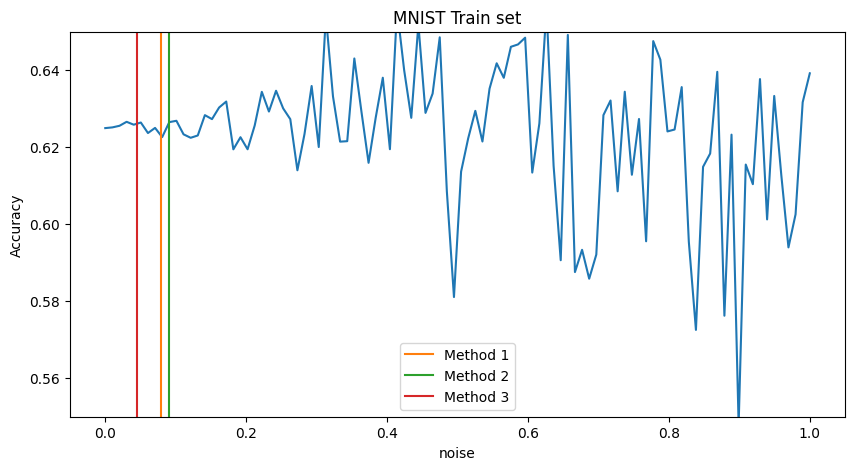

In [29]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(noises, train_accuracies)
plt.plot([ep1_train, ep1_train], [0, 1], label='Method 1')
plt.plot([ep2_train, ep2_train], [0, 1], label='Method 2')
plt.plot([ep3_train, ep3_train], [0, 1], label='Method 3')
plt.legend()
plt.ylim([0.55, 0.65])
plt.title('MNIST Train set')
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()

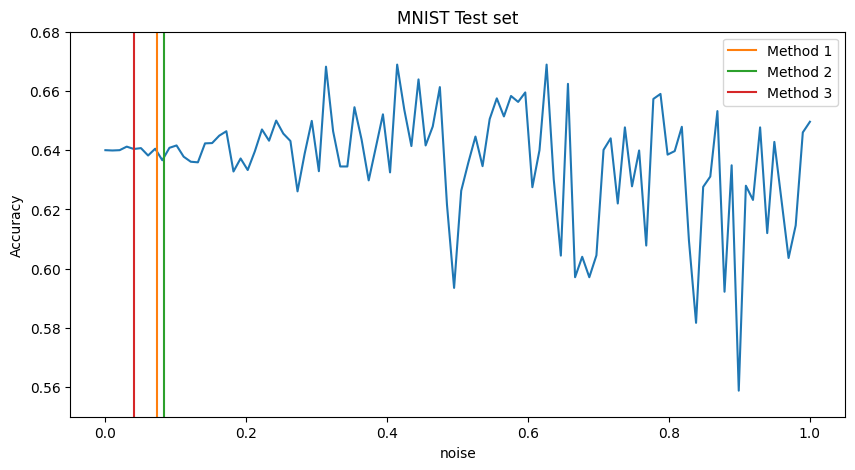

In [28]:
plt.figure(figsize=(10, 5), dpi=100)
plt.plot(noises, test_accuracies)
plt.plot([ep1_test, ep1_test], [0, 1], label='Method 1')
plt.plot([ep2_test, ep2_test], [0, 1], label='Method 2')
plt.plot([ep3_test, ep3_test], [0, 1], label='Method 3')
plt.legend()
plt.ylim([0.55, 0.68])
plt.title('MNIST Test set')
plt.xlabel('noise')
plt.ylabel('Accuracy')
plt.show()